In [1]:
import bluepysnap
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import numpy as np
import h5py

In [2]:
color_ndam ='#009FFD'
color_met = '#FFA400'
color_layer= {1:'#1BE7FF',2:'#60992D',3: '#FED766',4: '#D76A03', 5: '#922D50',6: '#B0A3D4'}

color_etype__dict = {'bNAC': (0.6509803921568628, 0.807843137254902, 0.8901960784313725), 'bSTUT': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765), 'cACint': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353), 'cADpyr': (0.2, 0.6274509803921569, 0.17254901960784313), 'cNAC': (0.984313725490196, 0.6039215686274509, 0.6), 'cSTUT': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745), 'dNAC': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883), 'dSTUT': (1.0, 0.4980392156862745, 0.0)}

In [3]:
import ast 
def safe_convert_to_array(value):
    try:
        return np.array(ast.literal_eval(value))  # Convert string to array
    except:
        return value  # If conversion fails, return the value as it is

In [4]:
# extract the surface area of the neurons
# data obtained with the python code Total_Area_neurons.py
# Data Folder can be downloaded from 10.5281/zenodo.14187063
df_area =  pd.read_csv('./Data/ComputeArea/area.csv')

In [5]:
#Extract cells that spike
# Data Folder can be downloaded from 10.5281/zenodo.14187063
file_path = './Data/spikes_ndam_met_aged.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df.drop(columns=['spikes_ndam','spikes_aged', 'spikes_met'], inplace=True)

In [6]:
#Extract feautures metabolism
#Obtained with thge code Efel_features_extraction.py
# Data Folder can be downloaded from 10.5281/zenodo.14187063
met_features = pd.read_csv('./Data/Data_Efel/metabolism/Features_extraction_metabolism.csv')

In [7]:
# Merge the two DataFrames on the matching columns
result = met_features.merge(df[['ids', 'etype', 'layer']], left_on='Node_ID', right_on='ids', how='left')
# Drop the 'ids' column as it's no longer needed after the merge
result = result.drop(columns=['ids'])
# Apply the function to 'etype' and 'layer' columns
result['AP_amplitude'] = [safe_convert_to_array(result['AP_amplitude'][i]).mean() for i in range(len(result['AP_amplitude']))]
result['peak_time'] = [safe_convert_to_array(result['peak_time'][i]) for i in range(len(result['AP_amplitude']))]

In [8]:
df = result.merge(df_area[['ids', 'Area']], left_on='Node_ID', right_on='ids', how='left')

In [9]:
f2 = 'layer'
f3 ='etype'

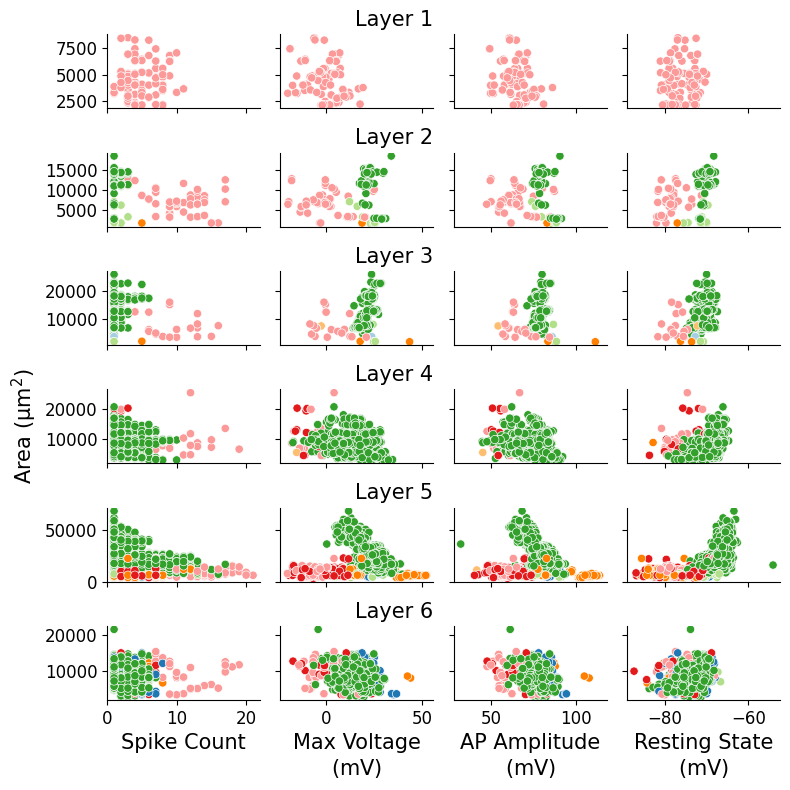

In [10]:
# List of variables to plot on the x-axis
variables = ['spike_count',  'maximum_voltage', 'AP_amplitude', 'steady_state_voltage_stimend']
variables_name = {'maximum_voltage': 'Max Voltage', 'spike_count': 'Spike Count', 'steady_state_voltage_stimend': 'Resting State', 'AP_amplitude':'AP Amplitude'}
units = { 'spike_count': '\n','maximum_voltage':'\n$(\mathrm{mV})$','steady_state_voltage_stimend':'\n$(\mathrm{mV})$','AP_amplitude':'\n$(\mathrm{mV})$'}
# Get the unique layers from the dataframe
layers = np.sort(df['layer'].unique())

# Set up the figure with a grid for the plots (6 rows for layers, 4 columns for variables)
fig, axes = plt.subplots(len(layers), len(variables), figsize=(8, 8), sharey='row', sharex='col')

# Flatten the axes for easy iteration
axes = axes.flatten()

# Create scatter plots for each variable and layer
for i, layer in enumerate(layers):
    for j, var in enumerate(variables):
        # Filter data for the current layer
        subset_data = df[df['layer'] == layer]
        
        # Create scatter plot for the current variable and layer, color-coded by 'etype'
        ax = axes[i * len(variables) + j]  # Position the axes in the correct grid location
        sns.scatterplot(x=var, y='Area', data=subset_data, hue=f3, ax=ax, palette=color_etype__dict, marker='o', legend=False)

        # Set labels and title
        if i == len(layers) - 1:  # Only set the x-label on the last row
            ax.set_xlabel(variables_name[var]+units[var], fontsize=15)
        ax.set_ylabel('')

            
        ax.spines[['top']].set_visible(False)
        ax.spines[['right']].set_visible(False)
        ax.tick_params(axis='both', labelsize=12)

        # Calculate the sample size per 'etype' and display it on the plot
        etype_counts = subset_data['etype'].value_counts()  # Get the counts for each 'etype'
axes[12].set_ylabel('Area $(\mathrm{\mu m}^2)$', fontsize=15)
axes[1].set_title('Layer 1', loc='right', fontsize=15)
axes[5].set_title('Layer 2', loc='right', fontsize=15)
axes[9].set_title('Layer 3', loc='right', fontsize=15)
axes[13].set_title('Layer 4', loc='right', fontsize=15)
axes[17].set_title('Layer 5', loc='right', fontsize=15)
axes[21].set_title('Layer 6', loc='right', fontsize=15)
#axes[0].text(x=-1.5, y=10, s='Layer 1', fontsize=14)

#         # Loop through the 'etype' counts and add them to the plot
#         y_offset = 0.08  # Initial vertical position for displaying counts
#         k=0
#         for etype, count in etype_counts.items():
#             ax.text(1., 1. - y_offset *k, f'{etype}: n={count}', transform=ax.transAxes, ha='right', va='top', fontsize=10, color='black')
#             #y_offset += 0.05  # Move down for the next etype's count
#             k+=1

# Adjust layout to avoid overlap
plt.tight_layout()

#plt.savefig("../Final_Figures/RESULTS/Figure5a.pdf", format="pdf", bbox_inches='tight')

In [11]:
from scipy.stats import pearsonr
import pandas as pd

# List of variables you want to analyze
variables = ['AP_amplitude', 'steady_state_voltage_stimend', 'spike_count', 'maximum_voltage']
f2 = 'layer'  # Column name for 'layer'
f3 = 'etype'  # Column name for 'etype'

# Initialize an empty dictionary to store the correlation and p-value for each layer, etype, and variable
correlation_p_values = {}

# Define the p-value threshold for filtering
p_value_threshold = 0.05

# Iterate over each variable, each layer, and each etype
for var in variables:
    for layer in df[f2].unique():  # Iterate through unique layers
        for etype in df[f3].unique():  # Iterate through unique etypes
            # Filter data for the current layer and etype
            subset_data = df[(df[f2] == layer) & (df[f3] == etype)]
            
            # Skip empty subsets or those with fewer than 20 data points
            if subset_data.shape[0] < 20:
                correlation_p_values[(layer, etype, var)] = {'correlation': None, 'p-value': None}
                continue
            
            # Calculate the correlation and p-value
            correlation, p_value = pearsonr(subset_data['Area'], subset_data[var])
            
            # Store the result using a tuple of (layer, etype, variable) as the key
            correlation_p_values[(layer, etype, var)] = {'correlation': correlation, 'p-value': p_value}

# Convert the result to a DataFrame for easy visualization
correlation_df = pd.DataFrame.from_dict(correlation_p_values, orient='index')

# Drop rows with p-values greater than the threshold (e.g., 0.05)
correlation_df = correlation_df[correlation_df['p-value'] <= p_value_threshold]

# Display the filtered correlation and p-value DataFrame
print(correlation_df)

                                       correlation        p-value
6 cADpyr AP_amplitude                    -0.223213   1.868926e-07
  bSTUT  AP_amplitude                    -0.640088   5.004831e-06
4 cADpyr AP_amplitude                    -0.146861   2.486901e-07
  cSTUT  AP_amplitude                    -0.535548   1.234789e-02
5 cADpyr AP_amplitude                    -0.662488  2.138149e-205
  dSTUT  AP_amplitude                    -0.475053   1.148745e-06
3 cADpyr AP_amplitude                     0.452187   4.172405e-22
1 cNAC   AP_amplitude                    -0.215113   3.838418e-02
2 cADpyr AP_amplitude                    -0.398478   5.289997e-05
6 cADpyr steady_state_voltage_stimend     0.388481   1.110899e-20
4 cADpyr steady_state_voltage_stimend     0.468842   7.475247e-68
5 cADpyr steady_state_voltage_stimend     0.460543   6.708212e-86
  cNAC   steady_state_voltage_stimend     0.318817   3.947508e-03
  bSTUT  steady_state_voltage_stimend     0.354807   4.275709e-02
3 cADpyr s

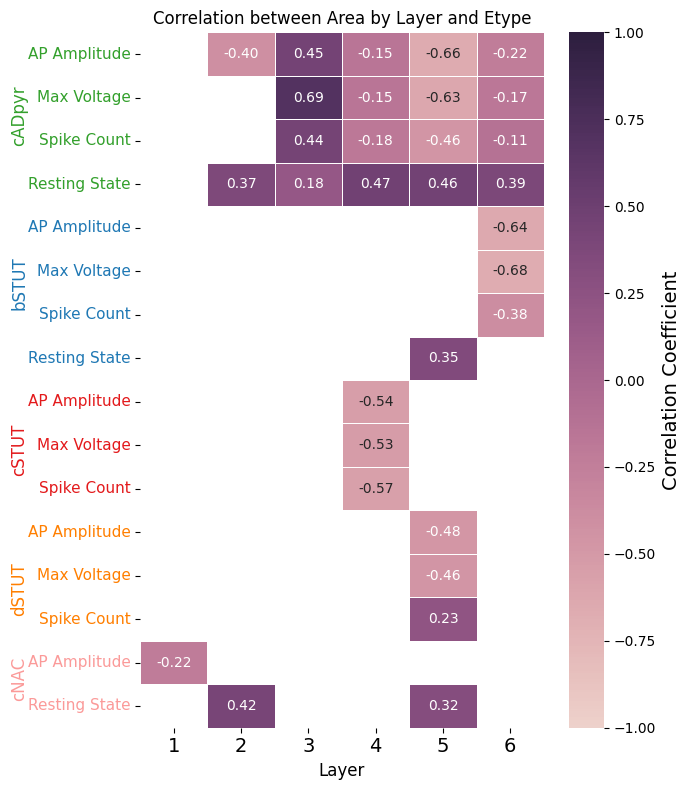

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

variables_name = {'maximum_voltage': 'Max Voltage', 'spike_count': 'Spike Count', 'steady_state_voltage_stimend': 'Resting State', 'AP_amplitude':'AP Amplitude'}
# Remove rows where correlation or p-value is None
correlation_df_clean = correlation_df.dropna()

# Pivot the DataFrame to make layers as columns
heatmap_df = correlation_df_clean['correlation'].unstack(level=0)  # Unstack to get layers as columns

# Plot a heatmap for the correlation values
plt.figure(figsize=(7, 8))
# Create the heatmap
ax = sns.heatmap(
    heatmap_df, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), center=0, 
    cbar_kws={'label': 'Correlation Coefficient'}, vmin=-1, vmax=1, fmt='.2f', linewidths=0.5
)

# Get the colorbar object
cbar = ax.collections[0].colorbar

# Set the font size of the colorbar label
cbar.set_label('Correlation Coefficient', fontsize=14)

new_y_labels = [f"{variables_name[var]}" for etype, var in heatmap_df.index]  # Custom labels combining etype and variable
ax.set_yticklabels(new_y_labels, rotation=0, fontsize=11)  # Rotate to 0 degrees and set a suitable font size

# Color the y-tick labels based on etype
for i, (etype, var) in enumerate(heatmap_df.index):
    label_color = color_etype__dict.get(etype, 'black')  # Default to black if etype is not found in dictionary
    ax.yaxis.get_ticklabels()[i].set_color(label_color)

# Increase x-tick label font size
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)  # Increase fontsize for x-tick labels
    
i=0.12
depth = -0.30
ax.text(depth, 1.-i, 'cADpyr', ha='center', va='center', fontsize=12, rotation=90, color= color_etype__dict.get('cADpyr', 'black'), transform=ax.transAxes)
ax.text(depth, 1.-i*3, 'bSTUT', ha='center', va='center', fontsize=12, rotation=90, color=color_etype__dict.get('bSTUT', 'black'), transform=ax.transAxes)
ax.text(depth, 1.-i*5, 'cSTUT', ha='center', va='center', fontsize=12, rotation=90, color=color_etype__dict.get('cSTUT', 'black'), transform=ax.transAxes)
ax.text(depth, 1.-i*7+0.04, 'dSTUT', ha='center', va='center', fontsize=12, rotation=90, color=color_etype__dict.get('dSTUT', 'black'), transform=ax.transAxes)
ax.text(depth, 1.-i*8+0.03, 'cNAC', ha='center', va='center', fontsize=12, rotation=90, color=color_etype__dict.get('cNAC', 'black'), transform=ax.transAxes)

    
# Title and axis labels
plt.title('Correlation between Area by Layer and Etype')
plt.xlabel('Layer', fontsize =12)
plt.ylabel('')
plt.tight_layout()
#plt.savefig("../Final_Figures/RESULTS/Figure5b.pdf", format="pdf", bbox_inches='tight')

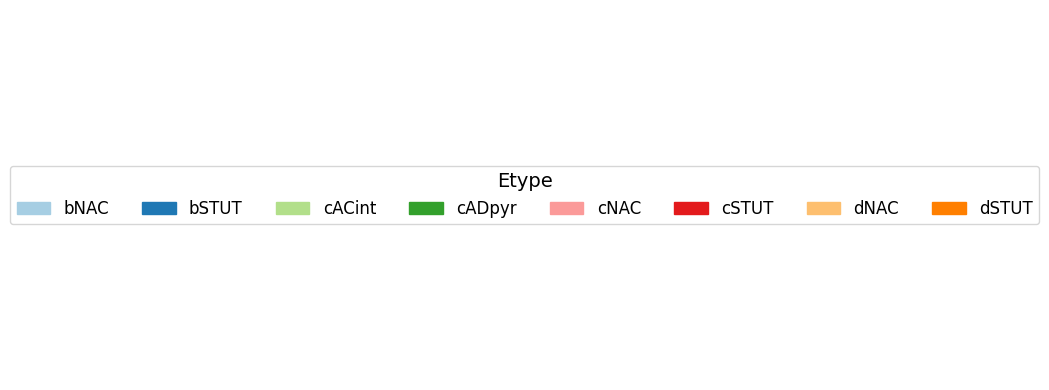

In [13]:
from matplotlib.patches import Patch
# Create legend handles
handles = [Patch(color=color, label=label) for label, color in color_etype__dict.items()]

# Create the plot
plt.figure(figsize=(6, 4))

# Add the legend with the custom handles
plt.legend(handles=handles, loc='center', fontsize=12, title='Etype', title_fontsize=14, ncol=8)

# Remove the axis from the plot
ax = plt.gca()  # Get the current axis
ax.set_axis_off()  # Remove axis

# Show the plot
plt.tight_layout()
#plt.savefig("../Final_Figures/RESULTS/Figure5AB-legend.pdf", format="pdf", bbox_inches='tight')